# ARIMA Forecasting

## Environment

In [1]:
import scipy as sp
print('scipy: %s' % sp.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# scikit-learn
import sklearn 
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels as sm
print('statsmodels: %s' % sm.__version__)

scipy: 0.19.1
numpy: 1.13.3
matplotlib: 2.1.1
pandas: 0.22.0
sklearn: 0.19.1
statsmodels: 0.8.0


## Validation Dataset

In [2]:
dataframe = pd.read_json('../pm25_05t.json')
series = pd.Series(data = dataframe['24hr_average_PM2.5 (ug/m3)'].values, index=dataframe['DateTime'].values)
split_point = int(len(series)*0.7)
print('Split dataset at index ',split_point)
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Split dataset at index  968
Dataset 968, Validation 416


## Baseline prediction

In [3]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# load data
series = pd.Series.from_csv('dataset.csv')

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 1.023


## Data Exploration

### Description

In [4]:
from pandas import Series
series = Series.from_csv('dataset.csv')
print(series.describe())

count    968.000000
mean      35.172573
std       21.490158
min        3.649500
25%       13.988178
50%       37.352250
75%       49.841000
max      103.199000
dtype: float64


### Line plot

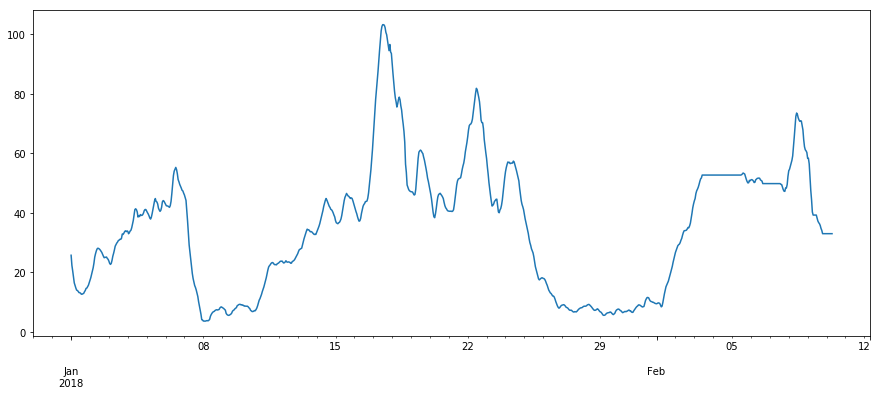

In [5]:
#plt.style.use('fivethirtyeight')
series.plot(figsize=(15, 6))
plt.show()

### Density plot

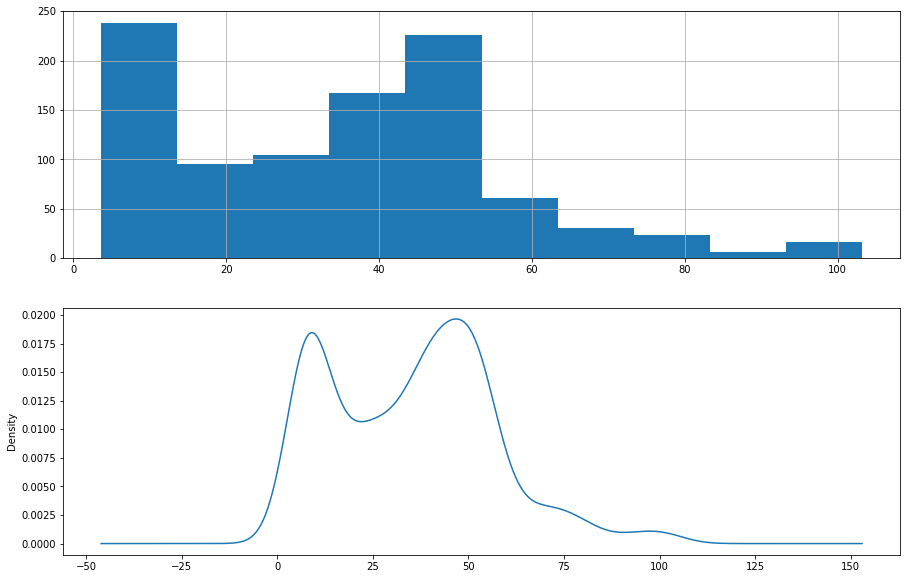

In [6]:
plt.figure(1)
plt.subplot(211)
series.hist(figsize=(15, 10))
plt.subplot(212)
series.plot(kind='kde')
plt.show()

## ARIMA Model

### Manually Configured ARIMA

ADF Statistic: -3.465458
p-value: 0.008920
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


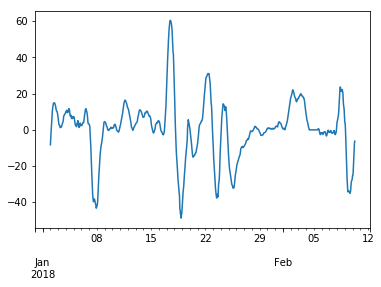

In [7]:
from statsmodels.tsa.stattools import adfuller

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

X = series.values
X = X.astype('float32')
# difference data
hours_in_day = 24
stationary = difference(X, hours_in_day)
stationary.index = series.index[hours_in_day:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
plt.show()

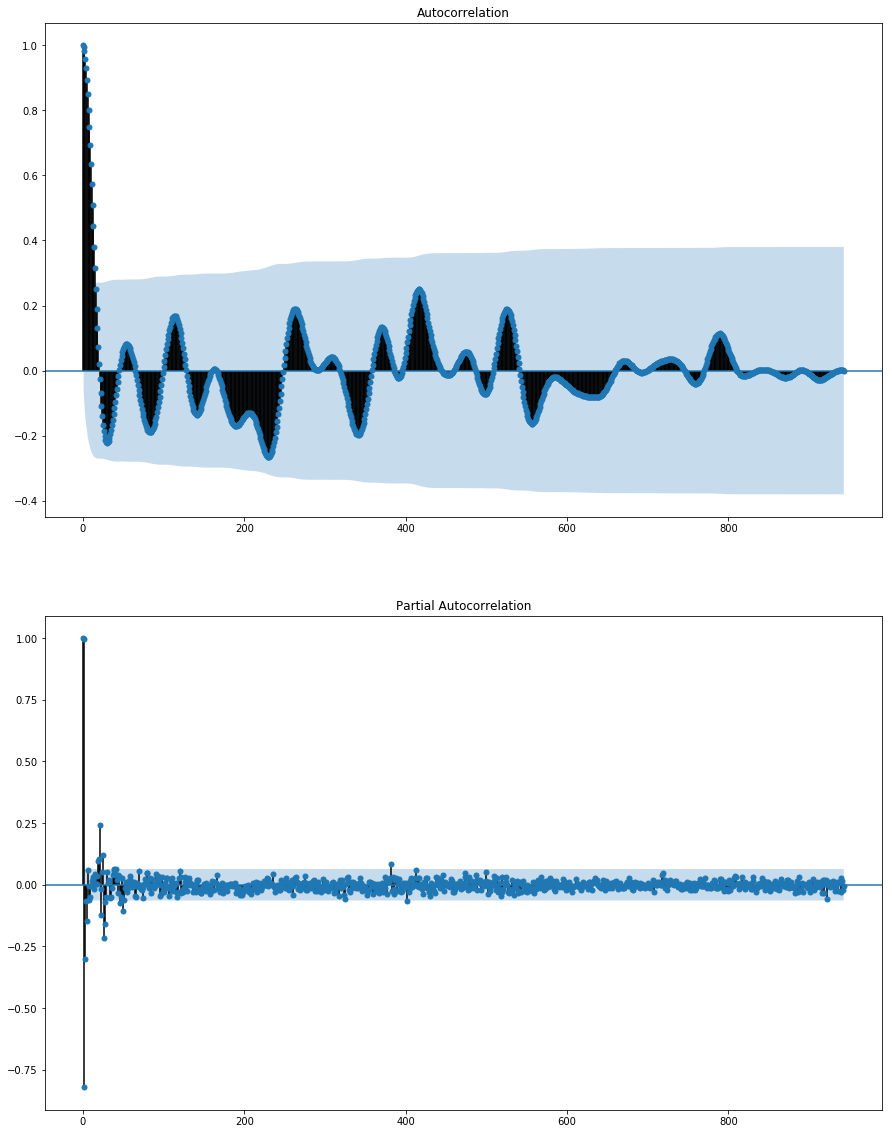

In [8]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
pyplot.figure(figsize=(15, 20))
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

### Grid Search ARIMA parameters

In [ ]:
# import warnings
# from pandas import Series
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import numpy

# # create a differenced series
# def difference(dataset, interval=1):
# 	diff = list()
# 	for i in range(interval, len(dataset)):
# 		value = dataset[i] - dataset[i - interval]
# 		diff.append(value)
# 	return numpy.array(diff)

# # invert differenced value
# def inverse_difference(history, yhat, interval=1):
# 	return yhat + history[-interval]

# # evaluate an ARIMA model for a given order (p,d,q) and return RMSE
# def evaluate_arima_model(X, arima_order):
# 	# prepare training dataset
# 	X = X.astype('float32')
# 	train_size = int(len(X) * 0.50)
# 	train, test = X[0:train_size], X[train_size:]
# 	history = [x for x in train]
# 	# make predictions
# 	predictions = list()
# 	for t in range(len(test)):
# 		# difference data
# 		hours_in_day = 24
# 		diff = difference(history, hours_in_day)
# 		model = ARIMA(diff, order=arima_order)
# 		model_fit = model.fit(trend='nc', disp=0)
# 		yhat = model_fit.forecast()[0]
# 		yhat = inverse_difference(history, yhat, hours_in_day)
# 		predictions.append(yhat)
# 		history.append(test[t])
# 	# calculate out of sample error
# 	mse = mean_squared_error(test, predictions)
# 	rmse = sqrt(mse)
# 	return rmse

# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
# 	dataset = dataset.astype('float32')
# 	best_score, best_cfg = float("inf"), None
# 	for p in p_values:
# 		for d in d_values:
# 			for q in q_values:
# 				order = (p,d,q)
# 				try:
# 					mse = evaluate_arima_model(dataset, order)
# 					if mse < best_score:
# 						best_score, best_cfg = mse, order
# 					print('ARIMA%s RMSE=%.3f' % (order,mse))
# 				except:
# 					continue
# 	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# # load dataset
# series = Series.from_csv('dataset.csv')
# # evaluate parameters
# p_values = range(0, 7)
# d_values = range(0, 3)
# q_values = range(0, 7)
# warnings.filterwarnings("ignore")
# #evaluate_models(series.values, p_values, d_values, q_values)

### Review Residual Errors

                0
count  484.000000
mean    -0.008821
std      0.733346
min     -3.042088
25%     -0.310262
50%      0.000401
75%      0.278296
max      2.781613


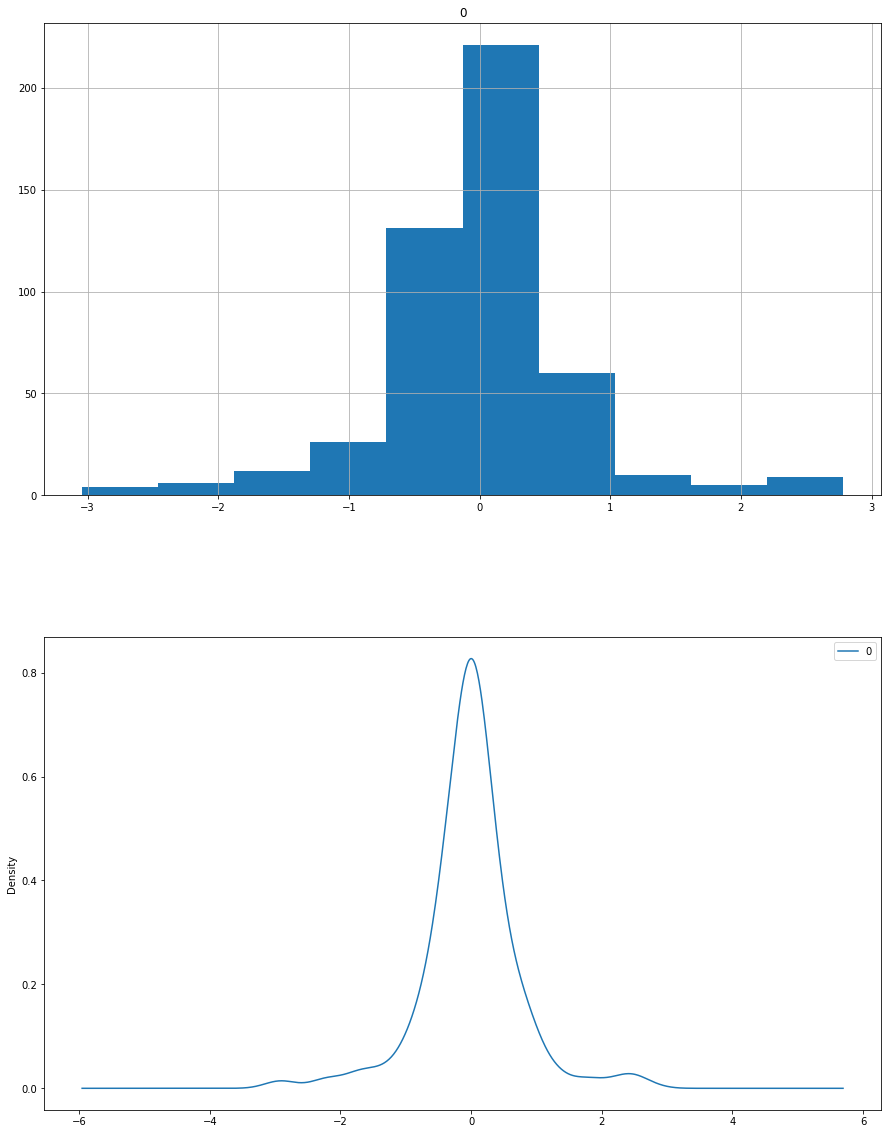

In [ ]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# difference data
	hours_in_day = 24
	diff = difference(history, hours_in_day)
	# predict
	model = ARIMA(diff, order=(2,0,5))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = inverse_difference(history, yhat, hours_in_day)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure(figsize=(15, 20))
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

RMSE: 0.733
                0
count  484.000000
mean    -0.007713
std      0.733346
min     -3.040980
25%     -0.309154
50%      0.001509
75%      0.279404
max      2.782721


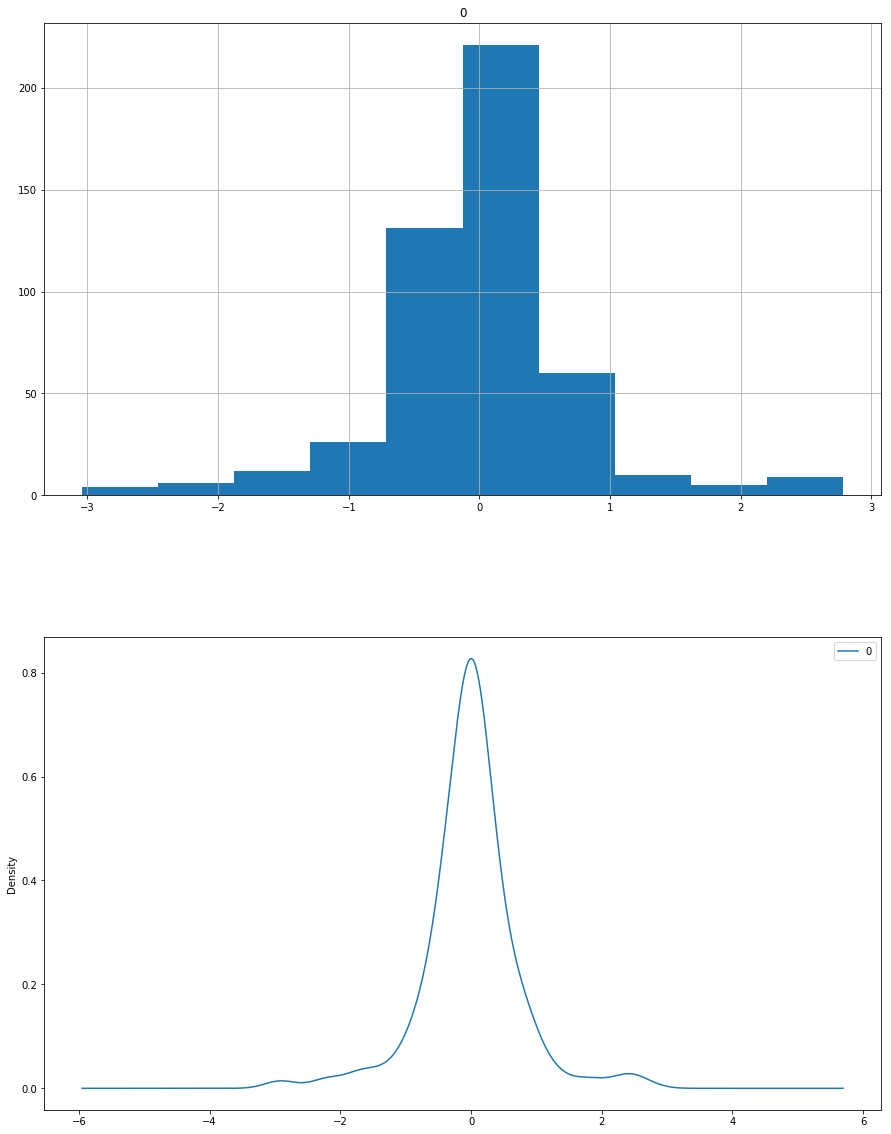

In [ ]:
from pandas import Series
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = -0.001108
for i in range(len(test)):
	# difference data
	hours_in_day = 24
	diff = difference(history, hours_in_day)
	# predict
	model = ARIMA(diff, order=(2,0,5))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	yhat = bias + inverse_difference(history, yhat, hours_in_day)
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure(figsize=(15, 20))
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

## Model Validation

### Finalize Model

In [ ]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
hours_in_day = 24
diff = difference(X, hours_in_day)
# fit model
model = ARIMA(diff, order=(2,0,5))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = -0.001108
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

### Make Prediction

In [ ]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
import numpy

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

series = Series.from_csv('dataset.csv')
hours_in_day = 24
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yhat, hours_in_day)
print('Predicted: %.3f' % yhat)

Predicted: 34.526


### Validate Model

>Predicted=34.526, Expected= 33
RMSE: 0.743


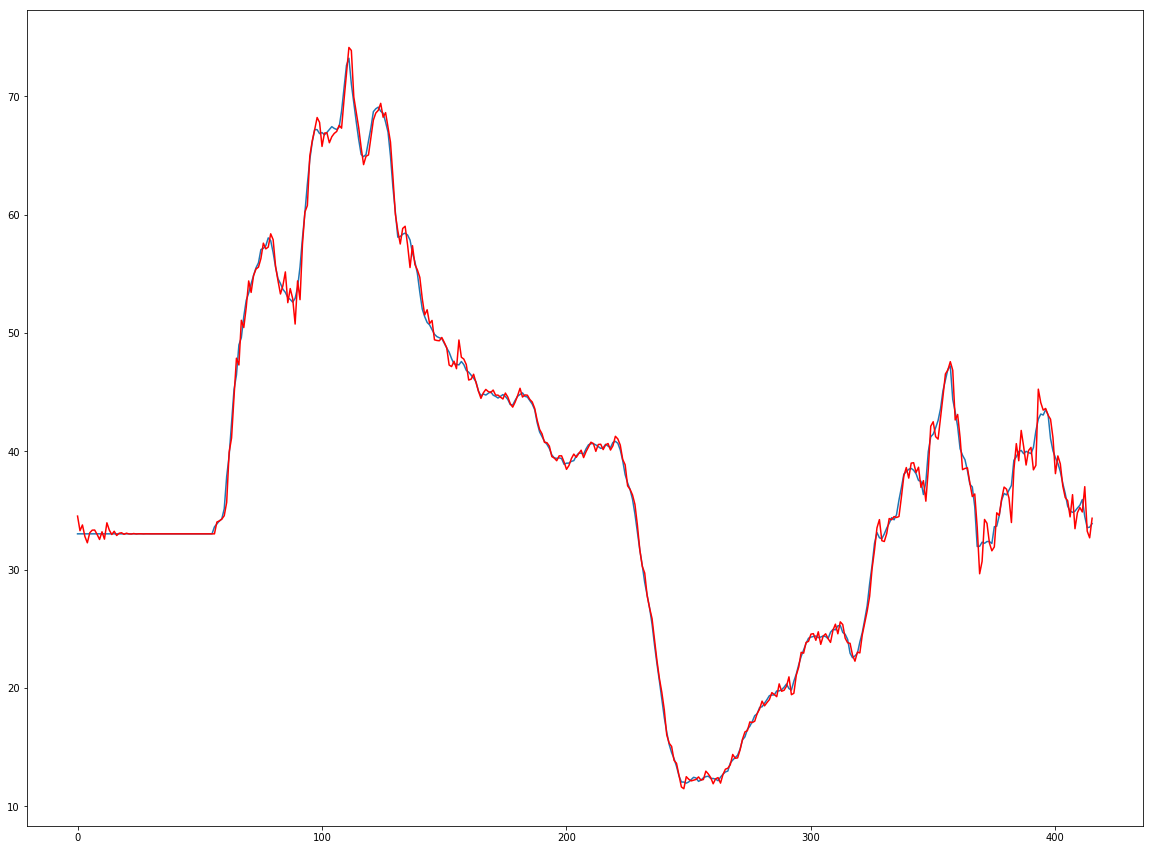

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float64')
history = [x for x in X]
hours_in_day = 24
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float64')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, hours_in_day)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # difference data
    hours_in_day = 24
    diff = difference(history, hours_in_day)
    # predict
    model = ARIMA(diff, order=(2,0,5))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, hours_in_day)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.figure(figsize=(20, 15))
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()